<a href="https://colab.research.google.com/github/walkingmug/sentiment-analysis-nlp/blob/main/Comments_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook learns from a labeled dataset of comments and tries to classify an unlabeled dataset of comments into 12 categories. It is possible for a comment to not fall into any category, or to fall into 2 or more categories at the same time.

Categories: Toxic, Abusive, Threat, Provocative, Obscene, Hatespeech, Racist, Nationalist, Sexist, Homophobic, Religious Hate, Radicalism.

Download the datasets from Kaggle.

In [8]:
# import libraries

import math
import nltk
import re
import sklearn
import string
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot as plt

nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**DATA ANALYSIS**

Analyse the youtube dataset and look for some useful information or patterns.

The youtube toxicity dataset contains 1000 comments that are hand-labeled into 12 categories. This dataset is used to train the model.

*Youtube toxic comments available at https://www.kaggle.com/datasets/reihanenamdari/youtube-toxicity-data*

In [9]:
# read the youtube dataset
youtube = pd.read_csv('youtoxic_english_1000.csv')

The youtube dataset is composed of 1000 rows and 13 columns. The first column is the comment text and the following 12 columns are the categories containing a value of True or False.

In [10]:
youtube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB


Looking at the top 5 rows of the dataset, two columns "CommentId" and "VideoId" appear to not be important in training the model, so they are removed.

In [11]:
youtube.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
youtube = youtube.drop(['CommentId', 'VideoId'], axis=1)

About half of the comments in the dataset do not belong into any of the 12 categories.

Text(0.5, 1.0, 'Categorization of YouTube comments dataset')

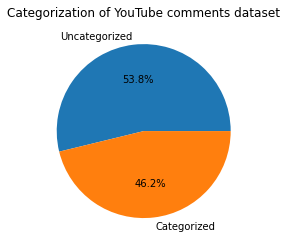

In [13]:
equal_rows = youtube.iloc[:, 1:][
           youtube.iloc[:, 1:].apply(pd.Series.nunique, axis=1) == 1]

plt.pie([equal_rows['IsToxic'].value_counts()[0],
         youtube.shape[0]-equal_rows['IsToxic'].value_counts()[0]],
        labels = ['Uncategorized', 'Categorized'], autopct='%1.1f%%')
plt.title('Categorization of YouTube comments dataset')

Separate the uncategorized comments from the categorized comments.

In [14]:
# uncategorized comments
indices_uncategorized = equal_rows.index.tolist()
yt_uncategorized = youtube.loc[indices_uncategorized]

# categorized comments
indices_categorized = []
for index in youtube.index.tolist():
  if index not in indices_uncategorized:
    indices_categorized.append(index)
yt_categorized = youtube.loc[indices_categorized]

# error-checking
if len(indices_uncategorized)+len(indices_categorized) \
   != len(youtube.index.tolist()):
  raise Exception(
      "Data may not have been split correctly. {} (uncategorized) + \
      {} (categorized) = {} which is different from {} (tot. rows)".format(
      len(indices_uncategorized), len(indices_categorized),
      len(indices_uncategorized)+len(indices_categorized),
      len(youtube.index.tolist())))


Apart from the Toxic class, the data is very imbalanced. Every class contains more examples of comments not belonging to it than it contains examples of comments that belong to that class. 

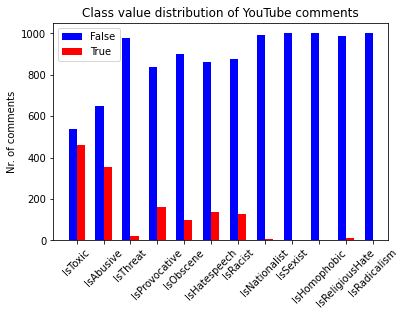

In [15]:
for _, col_name in enumerate(youtube.iloc[:, 1:]):
  counts = youtube[col_name].value_counts(sort=False)
  for val in counts.index.tolist():
    # check the class label and match it to the count
    if val is False:
      plt.bar(col_name, counts[0], width=-0.3, align='edge', label='False', color='blue')
    if val is True:
      plt.bar(col_name, counts[1], width=0.3, align='edge', label='True', color='red')
    if math.isnan(val):
      plt.bar(col_name, counts[1], width=0.3, align='edge', label='NaN', color='grey')

plt.xticks(rotation=45)
plt.title('Class value distribution of YouTube comments')
plt.ylabel('Nr. of comments')
  
# remove repeating legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


There are no missing comments and no unlabeled comments in the dataset.

In [16]:
def missing_data(df):
  """Checks for NaN values.
    Args:
        df (pd.DataFrame): A dataframe.
    Returns:
        int: Total NaN values found.
  """
  return sum(df.isna().sum().tolist())

In [17]:
missing_data(youtube)

0

The dataset has comments that may belong to 2 or more classes (max. 6 classes). Interestingly, there exists no comment that belongs to only 1 class. 

Text(0.5, 0, 'Nr. of classes that a comment belongs to')

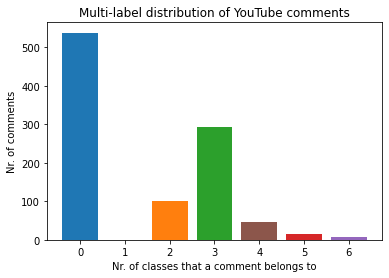

In [18]:
# get distribution of True values
lst = []
for row in range(youtube.shape[0]):
  lst.append(sum(youtube.iloc[row, 1:]))
counts = Counter(lst)

# plot distribution
for val in counts:
  plt.bar(val, counts.get(val))
plt.title('Multi-label distribution of YouTube comments')
plt.ylabel('Nr. of comments')
plt.xlabel('Nr. of classes that a comment belongs to')

In the categorized part of the dataset that has 1 or more True values, the average number of words is higher for Provocative, Hatespeech and Racist comments as opposed to when a comment wasn't marked as such.

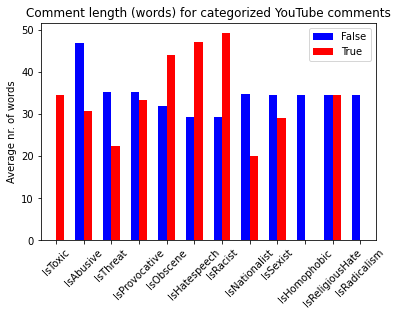

In [19]:
word_count_categorized = yt_categorized.copy()

# add a column with word count for each comment row
word_count_categorized['word_count'] = \
  word_count_categorized['Text'].apply(lambda x: len(str(x).split()))

# plot the distribution
for _, col_name in enumerate(youtube.iloc[:, 1:]):
  avg_uncategorized = word_count_categorized[
                   word_count_categorized[col_name]==False]['word_count'].mean()
  avg_categorized = word_count_categorized[
                  word_count_categorized[col_name]==True]['word_count'].mean()
  plt.bar(col_name, avg_uncategorized, width=-0.3, align='edge', label='False',
          color='blue')
  plt.bar(col_name, avg_categorized, width=0.3, align='edge', label='True',
          color='red')

plt.xticks(rotation=45)
plt.title('Comment length (words) for categorized YouTube comments')
plt.ylabel('Average nr. of words')

# remove repeating legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

Similarly, the character count for each class matches the word count.

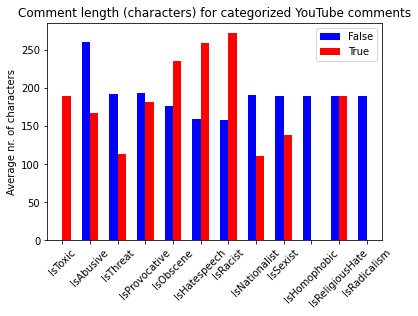

In [20]:
char_count_categorized = yt_categorized.copy()

# add a column with character count for each comment row
char_count_categorized['char_count'] = \
  char_count_categorized['Text'].apply(lambda x: len(str(x)))

# plot the distribution
for _, col_name in enumerate(youtube.iloc[:, 1:]):
  avg_uncategorized = char_count_categorized[
                   char_count_categorized[col_name]==False]['char_count'].mean()
  avg_categorized = char_count_categorized[
                  char_count_categorized[col_name]==True]['char_count'].mean()
  plt.bar(col_name, avg_uncategorized, width=-0.3, align='edge',
          label='False', color='blue')
  plt.bar(col_name, avg_categorized, width=0.3, align='edge', label='True',
          color='red')

plt.xticks(rotation=45)
plt.title('Comment length (characters) for categorized YouTube comments')
plt.ylabel('Average nr. of characters')

# remove repeating legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

**PRE-PROCESSING**

Clean up the texts to remove redundant information and mispronunciations

Pre-processing functions

In [21]:
def preprocess(text):
    """Simplifies text by removing unneccessary information.
    Args:
        text (str): A text to be cleaned.
    Returns:
        str: The cleaned text.
    """
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

def stopword(string):
    """Removes stop-words (e.g. "I","the","who", etc.)
    Args:
        string (str): A text to be inspected.
    Returns:
        str: Text without stop-words.
    """
    a = [i for i in string.split() if i not in 
         nltk.corpus.stopwords.words('english')]
    return ' '.join(a)

# use lemmatization (e.g. from "having" to "have")
wl = nltk.stem.WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    """Helper function to map NTLK position tags.
    Args:
        tag (str): A tag.
    Returns:
        str: A tag from WordNet.
    """
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

def lemmatizer(string):
    """Links words with similar meaning to one word.
    Args:
        string (str): A string to be inspected.
    Returns:
        str: A string.
    """
    word_pos_tags = nltk.pos_tag(nltk.tokenize.word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in 
       enumerate(word_pos_tags)]
    return " ".join(a)

def final_preprocess(string):
    """Calls above functions.
    Args:
        string (str): A text to be cleaned.
    Returns:
        str: The cleaned text.
    """
    return lemmatizer(stopword(preprocess(string)))

Use the pre-processing functions to clean-up the comments.

In [22]:
yt_clean = youtube.copy()
yt_clean['Clean_text'] = yt_clean['Text'].apply(lambda x: final_preprocess(x))

# print some examples
print('Before: "{}" \nAfter: "{}"'.format(
    yt_clean['Text'].iloc[1], yt_clean['Clean_text'].iloc[1]))

Streaming output truncated to the last 5000 lines.
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str

KeyboardInterrupt: ignored

Split the data into training set and test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    yt_clean["Clean_text"], yt_clean.iloc[:, 1:-1], test_size=0.3, shuffle=True,
    random_state=42)

Checking how much of the categorized data ended up in train and test set allows for the training model to not be biased. In this case, the train and test sets have about half of each.

In [ ]:
len_uncat_train = len(y_train[y_train.apply(pd.Series.nunique, axis=1) == 1].index.tolist())
len_uncat_test = len(y_test[y_test.apply(pd.Series.nunique, axis=1) == 1].index.tolist())
len_train = len(y_train.index.tolist())
len_test = len(y_test.index.tolist())

print("train: {} uncategorized out of {} ({}%)".format(
    len_uncat_train, len_train, round(len_uncat_train / len_train * 100, 1)))
print("test: {} uncategorized out of {} ({}%)".format(
    len_uncat_test, len_test, round(len_uncat_test / len_test * 100, 1)))

**MACHINE LEARNING MODEL**

Learning a model that will (hopefully) classify future comments into categories.

In [ ]:
# create a list of categories
categories = list(y_test.columns.values)

Logistic regression

This model gives decent results, with the lowest accuracy for the Toxic class at 68%.

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))

# create a pipeline
logistic_regression = Pipeline([
                    ('tfidf', sklearn.feature_extraction.text.TfidfVectorizer(
                      stop_words=stop_words)),
                    ('clf', OneVsRestClassifier(
                      sklearn.linear_model.LogisticRegression(solver='sag'),
                      n_jobs=1)),
                    ])

# predict each category and measure accuracy
for category in categories:
    logistic_regression.fit(X_train, y_train[category])
    prediction = logistic_regression.predict(X_test)
    print('{}: {}'.format(category, round(sklearn.metrics.accuracy_score(
        y_test[category], prediction), 2)))

Naive Bayes

Gives similar results to logistic regression.

In [ ]:
# create a pipeline
naive_bayes = Pipeline([
            ('tfidf', sklearn.feature_extraction.text.TfidfVectorizer(
              stop_words=stop_words)),
            ('clf', OneVsRestClassifier(MultinomialNB(
              fit_prior=True, class_prior=None))),
            ])
for category in categories:
    naive_bayes.fit(X_train, y_train[category])
    prediction = naive_bayes.predict(X_test)
    print('{}: {}'.format(category, round(sklearn.metrics.accuracy_score(
        y_test[category], prediction), 2)))

**PREDICTING UNLABELED DATA**

The Reddit depression dataset contains about 7000 comments from Reddit that are labeled as 1 if the comment falls into the depression category or 0 otherwise.

Depression: Reddit Dataset available at https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned

PRE-PROCESSING

In [ ]:
reddit = pd.read_csv('depression_dataset_reddit_cleaned.csv')
reddit.head()

The depression dataset is originally used to detect whether a comment is of depressive nature. This column is not needed for this example. The same comments are checked if they contain any of the 12 classes from the youtube dataset.

In [ ]:
# add the categories columns
reddit = reddit.reindex(reddit.columns.tolist() + youtube.columns[1:].tolist(),
                        axis=1)

# drop labels
reddit = reddit.drop(['is_depression'], axis=1)

# rename for consistency
reddit = reddit.rename(columns={'clean_text':'Text'})   
reddit.head()

Clean the text using the previous functions. Even though the dataset was posted cleaned, we may try to further clean it.



In [ ]:
reddit_clean = reddit.copy()
reddit_clean['Clean_text'] = reddit_clean['Text'].apply(lambda x: final_preprocess(x))

# print some examples
print('Before: "{}" \nAfter: "{}"'.format(
    reddit_clean['Text'].iloc[1], reddit_clean['Clean_text'].iloc[1]))

Classifying using logistic regression.

In [ ]:
for category in categories:
    logistic_regression.fit(X_train, y_train[category])
    prediction = logistic_regression.predict(reddit_clean['Clean_text'])
    reddit_clean[category] = prediction

**RESULTS**

There are no unlabeled columns. The prediction didn't miss anything.

In [ ]:
missing_data(reddit_clean)

About 89% of the predicted comments do not belong into any of the 12 classes.

In [ ]:
equal_rows = reddit_clean.iloc[:, 1:-1][
  reddit_clean.iloc[:, 1:-1].apply(pd.Series.nunique, axis=1) == 1]

plt.pie([equal_rows['IsToxic'].value_counts()[0],
         reddit_clean.shape[0]-equal_rows['IsToxic'].value_counts()[0]],
        labels = ['Uncategorized', 'Categorized'], autopct='%1.1f%%')
plt.title('Categorization of Reddit comments predictions')

Most comments are not labeled into any class, but there exist comments that belong to 1, 2 or 3 classes at the same time.

In [ ]:
# get distribution of True values
lst = []
for row in range(reddit_clean.shape[0]):
  lst.append(sum(reddit_clean.iloc[row, 1:-1]))
counts = Counter(lst)

# plot distribution
for val in counts:
  plt.bar(val, counts.get(val))
plt.title('Multi-label distribution of Reddit comments')
plt.ylabel('Nr. of comments')
plt.xlabel('Nr. classes that a comment belongs to')

The categorized comments may fall into 4 out of the 12 total categories: Toxic, Abusive, Provocative, or Obscene. Most of them contain the category Toxic.

In [ ]:
plt.bar(reddit_clean.iloc[:, 1:-1].columns, reddit_clean.iloc[:, 1:-1].sum())
plt.xticks(rotation=45)
plt.title('Category of comments')
plt.ylabel('Nr. of comments')